In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import mlflow
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

from lib.reproduction import major_oxides



In [9]:
from lib import full_flow_dataloader
from lib.cross_validation import custom_kfold_cross_validation_new


# Load the data and create folds
def get_data_indices(target: str):
    # Simulate loading the data
    train_full, test_full = full_flow_dataloader.load_full_flow_data(load_cache_if_exits=True, average_shots=True)
    full_data = pd.concat([train_full, test_full], axis=0)

    # Generate custom folds
    folds, train, test = custom_kfold_cross_validation_new(
        data=full_data, k=5, group_by="Sample Name", target=target, random_state=42
    )

    train_indices = train.index.values
    index_mapping = {idx: pos for pos, idx in enumerate(train_indices)}

    # Convert DataFrame-based folds to index-based folds
    fold_indices = []
    for train_fold, test_fold in folds:
        train_fold_idx = [index_mapping[idx] for idx in train_fold.index.values if idx in index_mapping]
        test_fold_idx = [index_mapping[idx] for idx in test_fold.index.values if idx in index_mapping]
        fold_indices.append((train_fold_idx, test_fold_idx))

    return fold_indices, train, test, full_data, full_data[target]

In [10]:
target = "SiO2"
assert target in major_oxides, f"Target {target} not in major_oxides"
drop_cols = major_oxides + ["ID", "Sample Name"]

fold_indices, train_data, test_data, full_data, y_full = get_data_indices(target=target)
X_full = full_data.drop(columns=drop_cols)

In [11]:
# Manually perform cross-validation to generate predictions from base estimators
def perform_manual_cv(fold_indices, X_full, y_full, base_estimators):
    meta_features = np.zeros((X_full.shape[0], len(base_estimators)))
    for i, (train_idx, test_idx) in enumerate(fold_indices):
        X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]

        for j, (name, estimator) in enumerate(base_estimators):
            estimator.fit(X_train, y_train)
            meta_features[test_idx, j] = estimator.predict(X_test)

    return meta_features


# meta_features = perform_manual_cv(
#     fold_indices, X_full, y_full, sio2_pipeline
# )

In [12]:
# Perform cross-validation for the final estimator using the meta-features
def perform_final_cv(fold_indices, meta_features, y_full, final_estimator, metric_fns):
    cv_metrics = []
    for train_idx, test_idx in fold_indices:
        X_train, X_test = meta_features[train_idx], meta_features[test_idx]
        y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]

        final_estimator.fit(X_train, y_train)
        y_pred = final_estimator.predict(X_test)

        fold_metrics = [metric_fn(y_test, y_pred) for metric_fn in metric_fns]
        cv_metrics.append(fold_metrics)

    return cv_metrics

In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

final_estimator = ElasticNet(alpha=0.1)

In [14]:
from lib.metrics import rmse_metric, std_dev_metric

metric_fns = [rmse_metric, std_dev_metric]

In [15]:
from experiments.stacking_pipelines import make_oxide_pipelines

oxide_pipelines = make_oxide_pipelines()

In [16]:
def do_cv_metrics(cv_metrics):
    rmse_cv_scores = [metrics[0] for metrics in cv_metrics]
    rmse_cv_mean = np.mean(rmse_cv_scores)
    rmse_cv_std = np.std(rmse_cv_scores)
    print(f"RMSECV: {rmse_cv_mean} ± {rmse_cv_std}")

    std_dev_cv_scores = [metrics[1] for metrics in cv_metrics]
    std_dev_cv_mean = np.mean(std_dev_cv_scores)
    std_dev_cv_std = np.std(std_dev_cv_scores)
    print(f"STDCV: {std_dev_cv_mean} ± {std_dev_cv_std}")

    return {
        "rmse_cv_mean": rmse_cv_mean,
        "rmse_cv_std": rmse_cv_std,
        "std_dev_cv_mean": std_dev_cv_mean,
        "std_dev_cv_std": std_dev_cv_std,
    }

In [17]:
from experiments.stacker import Stacker
from lib.one_to_one_plots import plot_actual_vs_predicted

def run(target: str):
    fold_indices, train_data, test_data, full_data, y_full = get_data_indices(target=target)
    X_full = train_data.drop(columns=drop_cols)
    y_full = train_data[target]
    pipeline = oxide_pipelines[target]

    stacker = Stacker(base_estimators=pipeline, final_estimator=final_estimator)
    stacker.fit_cv(X_full, y_full, fold_indices)
    meta_features = stacker.meta_features_
    cv_metrics = stacker.cv(fold_indices, meta_features, y_full, final_estimator, metric_fns)
    metrics = do_cv_metrics(cv_metrics)

    X_train_final = train_data.drop(columns=drop_cols)
    y_train_final = train_data[target]
    X_test_final = test_data.drop(columns=drop_cols)
    y_test_final = test_data[target]

    stacker.fit(X_train_final, y_train_final)
    y_pred_final = stacker.predict(X_test_final)
    rmsep_final = rmse_metric(y_test_final, y_pred_final)
    std_dev_final = std_dev_metric(y_test_final, y_pred_final)
    print(f"RMSEP: {rmsep_final}")

    metrics["RMSEP"] = rmsep_final
    metrics["STDDEV"] = std_dev_final

    plot_actual_vs_predicted(
        actual_values=y_test_final,
        predicted_values=y_pred_final,
        rmse=rmsep_final,
        std_dev=std_dev_final,
        oxide=target,
        plot_path="/home/christian/projects/p9/baseline/plots/_one_to_one/enet_a_01",
    )

    return metrics

2024/06/11 16:55:52 INFO mlflow.tracking.fluent: Experiment with name 'Stacking Ensemble 2024-06-11 16:55:52' does not exist. Creating a new experiment.


RMSECV: 4.68604655188944 ± 0.4886195260560365
STDCV: 4.6765235401205345 ± 0.50493532690412
RMSEP: 3.5975916228922844


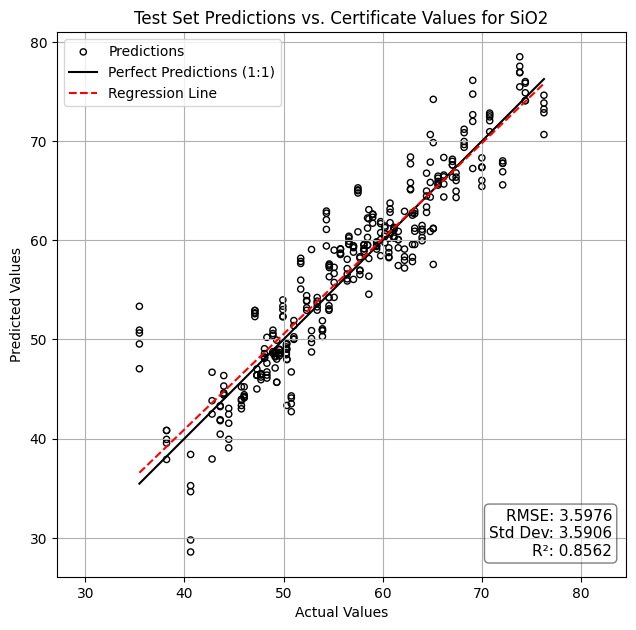

RMSECV: 0.4501106089293434 ± 0.08280432748587391
STDCV: 0.4484863525414192 ± 0.08318808698709275
RMSEP: 0.3185123167685472


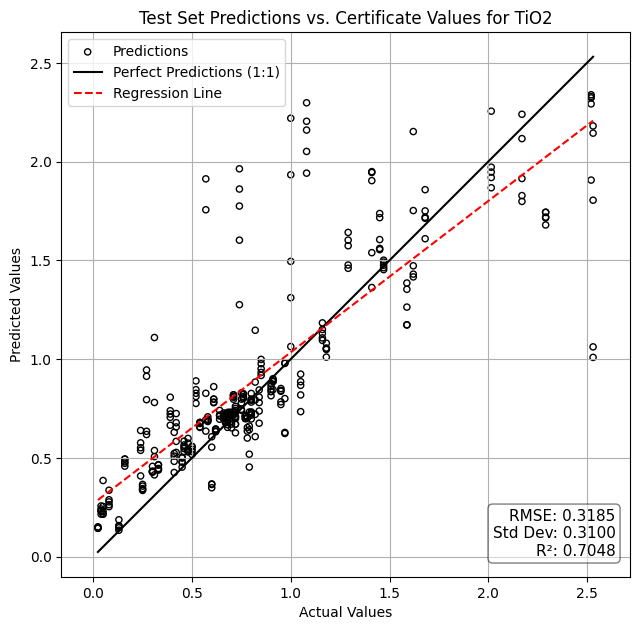

RMSECV: 2.1916905133405535 ± 0.23511646779715162
STDCV: 2.179671033066384 ± 0.23786038575600638
RMSEP: 1.6584539122594906


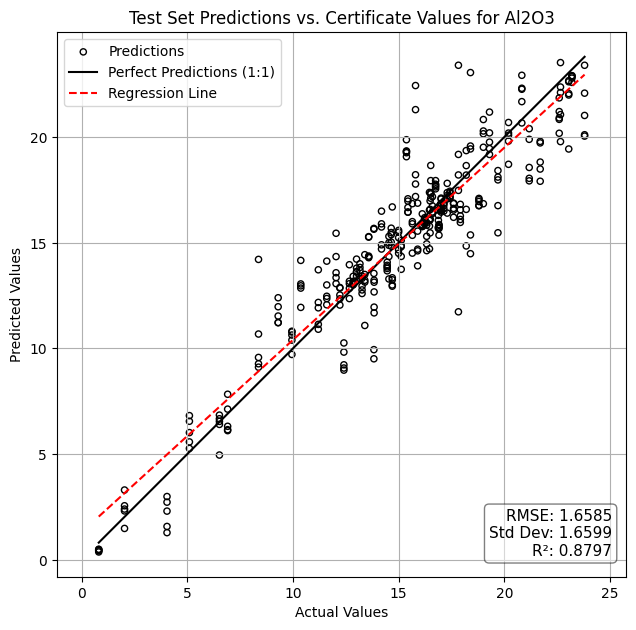

RMSECV: 2.7806323982900074 ± 0.664028378678059
STDCV: 2.731333828502475 ± 0.6592917519285604
RMSEP: 1.8414854430634378


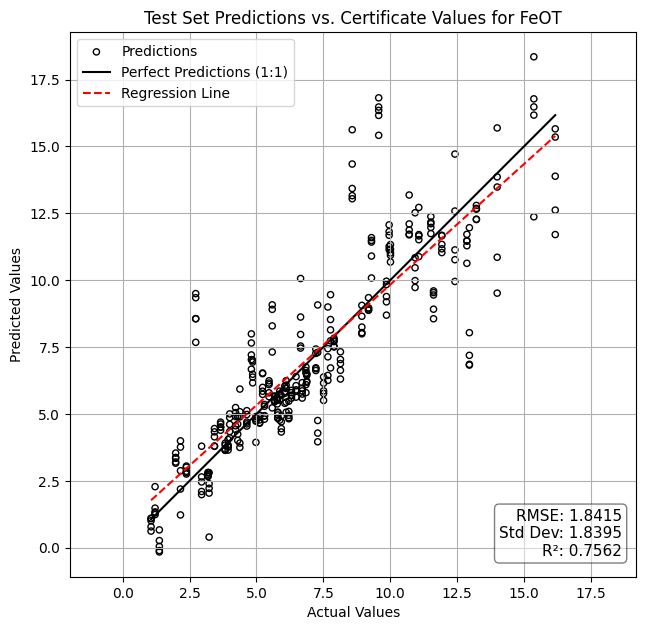

RMSECV: 1.6320277769666407 ± 0.5314225885212956
STDCV: 1.6084006902823567 ± 0.5177651160295886
RMSEP: 0.7676279035119392


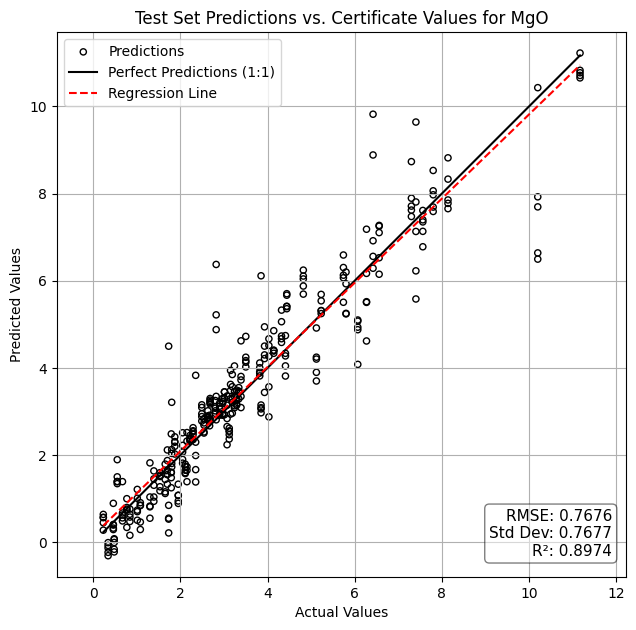

RMSECV: 1.3095377067547849 ± 0.21347712756124948
STDCV: 1.2914260292363622 ± 0.21056706436859438
RMSEP: 1.647486991298954


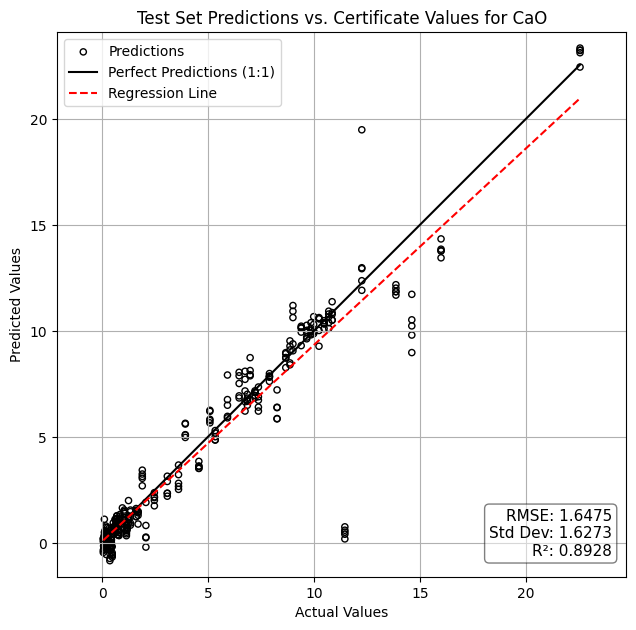

RMSECV: 1.092591708280447 ± 0.6897231129325169
STDCV: 1.0788672606492238 ± 0.6917475136992287
RMSEP: 0.44234465756397495


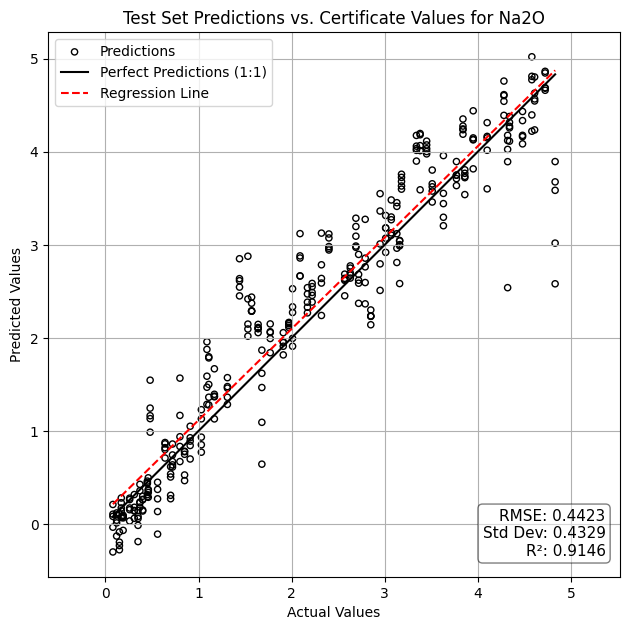

RMSECV: 0.5555301770105958 ± 0.15517289471842366
STDCV: 0.5530344253652779 ± 0.1531827587080751
RMSEP: 0.49375337359102145


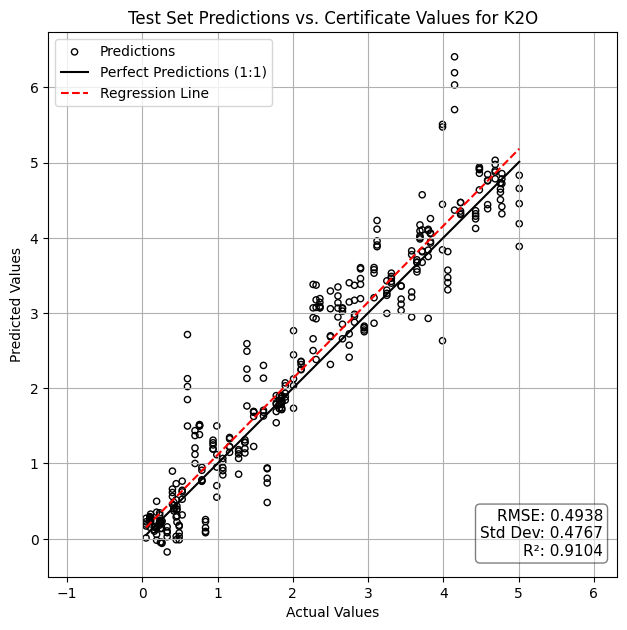

In [18]:
import time

current_time = time.strftime("%Y-%m-%d %H:%M:%S")
experiment_name = f"Stacking Ensemble {current_time}"
mlflow.set_experiment(experiment_name)

for target in major_oxides:
    with mlflow.start_run(
        run_name=f"{target}_{final_estimator.__class__.__name__}",
        description=f"Final stacking ensemble for {target} using {final_estimator.__class__.__name__}",
    ):
        metrics = run(target)
        mlflow.log_metrics(metrics)

In [ ]:
from itertools import combinations
from experiments.stacker import Stacker
from experiments.stacking_pipelines import tio2_instantiate_all_models
import mlflow

oxide = "TiO2"
experiment_name = f"{oxide} Combination Optimization - Stacker"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except mlflow.exceptions.MlflowException as e:
    if "RESOURCE_ALREADY_EXISTS" in str(e):
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    else:
        raise e


def generate_combinations(models, min_len, max_len):
    """Generate all combinations of the models between the given lengths."""
    all_combinations = []
    for i in range(min_len, max_len + 1):
        comb = list(combinations(models, i))
        all_combinations.extend(comb)
    return all_combinations

tio2_all_models = tio2_instantiate_all_models()


def run(target: str, model_combinations, final_estimator, metric_fns, drop_cols):
    best_metrics = None
    best_combination = None

    for combo in model_combinations:
        print(f"Evaluating combination: {combo}")

        # Prepare the pipeline with the current combination of base estimators
        pipeline = [(model, tio2_all_models[model]) for model in combo]

        fold_indices, train_data, test_data, full_data, y_full = get_data_indices(target=target)
        X_full = full_data.drop(columns=drop_cols)

        stacker = Stacker(base_estimators=pipeline, final_estimator=ElasticNet())
        stacker.fit_cv(X_full, y_full, fold_indices)
        meta_features = stacker.meta_features_
        cv_metrics = stacker.cv(fold_indices, meta_features, y_full, final_estimator, metric_fns)
        metrics = do_cv_metrics(cv_metrics)

        X_train_final = train_data.drop(columns=drop_cols)
        y_train_final = train_data[target]
        X_test_final = test_data.drop(columns=drop_cols)
        y_test_final = test_data[target]

        stacker.fit(X_train_final, y_train_final)
        y_pred_final = stacker.predict(X_test_final)
        rmsep_final = rmse_metric(y_test_final, y_pred_final)
        print(f"RMSEP: {rmsep_final}")

        metrics["RMSEP"] = rmsep_final

        # Log metrics to mlflow
        with mlflow.start_run(experiment_id=experiment_id, run_name=f"Combination: {combo}"):
            mlflow.log_params({"base_estimators": combo, "final_estimator": final_estimator.__class__.__name__})
            mlflow.log_metrics(metrics)

        # Keep track of the best combination
        if best_metrics is None or metrics["RMSEP"] < best_metrics["RMSEP"]:
            best_metrics = metrics
            best_combination = combo

    print(f"Best combination: {best_combination} with RMSEP: {best_metrics['RMSEP']}")
    return best_metrics


# Define the models and final estimator
top_models = ["svr", "gbr", "xgboost", "rf", "elasticnet", "extra_trees", "ridge", "lasso", "pls"]
final_estimator = SVR()
metric_fns = [rmse_metric, std_dev_metric]
drop_cols = major_oxides + ["ID", "Sample Name"]

# Generate all possible combinations of the top models
model_combinations = generate_combinations(top_models, min_len=2, max_len=3)

# Run the grid search for the best stacking ensemble configuration
results = run(
    target=oxide,
    model_combinations=model_combinations,
    final_estimator=final_estimator,
    metric_fns=metric_fns,
    drop_cols=drop_cols,
)